# labelling
Purpose: Create all the labels needed
- number of appearances in past 24h
- number of appearences in past 3 days
- btc sma price movement for past 7 days
- current price compared to high/low of past 2 hours
- price gain over past 2 hours, 12 hours
- pct gain compared to top 5 peers: special one? Or all rallying?
- Is continuation? To which degree? ie 1 if previous was also that
- is high bar also the largest bar (high-low) and has the highest volume?
- From high and low of previous 2 hours, where placed now?

- new target, sma with time weighting

In [1]:
import sys
sys.path.append('../')
import binance_helpers as bh
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ui
import importlib
import time
from datetime import datetime, timedelta
client = bh.new_binance_client("../")


In [3]:
trades = pd.read_csv("../data/trades.csv", index_col=0, parse_dates=True).iloc[-15000:]

In [4]:
trades

,trades,pret,target
timestamp,,,
2018-09-01 20:00:00,neo,0.020812,0.005058
2018-09-01 22:00:00,etc,-0.004364,0.003322
2018-09-02 00:00:00,bnb,0.005295,0.011510
2018-09-02 02:00:00,eth,-0.005151,-0.009127
2018-09-02 04:00:00,icx,0.038464,0.012468
...,...,...,...
2022-02-02 10:00:00,people,0.056599,0.015369
2022-02-02 12:00:00,agld,0.272371,0.097045
2022-02-02 14:00:00,idex,0.171811,-0.179169


In [38]:
def analyze(trades, func):
    result = []
    for _ in range(len(func)):
        result.append([])
    i = 0
    length = len(trades)
    for i in range(length):
        s = trades.iloc[i].name
        e = s+timedelta(hours=0)
        ss = (s-timedelta(hours=2)).strftime("%d %b %Y %H:%M:%S")
        es = (e+timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")
        try:
            name = trades.iloc[i].trades.upper()+"USDT"
            klines = client.get_historical_klines(symbol=name, interval = "1m", start_str=ss, end_str=es)
            btc = client.get_historical_klines(symbol="BTCUSDT", interval = "1m", start_str=ss, end_str=es)
            for j in range(len(func)):
                try:
                    result[j].append(func[j](klines, btc))
                except:
                    print(f"Warning: failed for function #{j} for trades.iloc[{i}]")
                    result[j].append(0)
        except:
            print(f"Warning: failed for trades.iloc[{i}]")
            for j in range(len(func)):
                result[j].append(0)
        i += 1
        ui.printProgressBar(i, length)
    return result

In [8]:
s = trades.iloc[6].name
e = s+timedelta(hours=2)
ss = (s-timedelta(hours=2)).strftime("%d %b %Y %H:%M:%S")
es = (e+timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")

In [9]:
trades.iloc[6]

trades         xlm
pret     -0.000865
target    0.017442
Name: 2018-09-02 08:00:00, dtype: object

In [13]:
name = trades.iloc[6].trades.upper()+"USDT"
klines = client.get_historical_klines(symbol=name, interval = "1m", start_str=ss, end_str=es)
btc = client.get_historical_klines(symbol="BTCUSDT", interval = "1m", start_str=ss, end_str=es)


In [41]:
a = get_klines_over_btc(klines, btc)

In [44]:
def gain(klines, btc):
    k = get_klines_over_btc(klines, btc)
    return (max(k['high'])-min(k['low']))/min(k['low'])

def current_height(klines, btc):
    """current placement % of high and low"""
    k = get_klines_over_btc(klines, btc)
    total = max(k['high'])-min(k['low'])
    end = k['close'][-1]-min(k['low'])
    return end/total
    
    
    
def get_index(klines, i):
    return list(map(lambda x: float(x[i]), klines))

def get_klines_over_btc(klines, btc):
    return {"open":list(map(lambda x, y: x/y, get_index(klines, 1), get_index(btc, 4))),
            "high":list(map(lambda x, y: x/y, get_index(klines, 2), get_index(btc, 4))),
            "low":list(map(lambda x, y: x/y, get_index(klines, 3), get_index(btc, 4))),
            "close":list(map(lambda x, y: x/y, get_index(klines, 4), get_index(btc, 4)))
           }

In [45]:
result = analyze(trades, [gain, current_height])

 |██████████████████████████████████████████████████| 100.0% 


In [48]:
df = pd.DataFrame({"gain":result[0], "pct":result[1]}, index=trades.index)


In [50]:
trades['gain'] = result[0]
trades['pct'] = result[1]

In [66]:
trades['cont'] = trades.trades == trades.shift().trades
trades['cont'] = list(map(lambda x: 1 if x else 0, trades.cont))

In [67]:
trades

,trades,pret,target,gain,pct,cont
timestamp,,,,,,
2018-09-01 20:00:00,neo,0.020812,0.005058,0.038342,0.668358,0
2018-09-01 22:00:00,etc,-0.004364,0.003322,0.012289,0.575085,0
2018-09-02 00:00:00,bnb,0.005295,0.011510,0.014187,0.772294,0
2018-09-02 02:00:00,eth,-0.005151,-0.009127,0.010059,0.419270,0
2018-09-02 04:00:00,icx,0.038464,0.012468,0.045982,0.880761,0
...,...,...,...,...,...,...
2022-02-02 10:00:00,people,0.056599,0.015369,0.096670,0.607124,0
2022-02-02 12:00:00,agld,0.272371,0.097045,0.347118,0.795332,0
2022-02-02 14:00:00,idex,0.171811,-0.179169,0.261487,0.792320,0


In [68]:
trades.iloc[-10:]

,trades,pret,target,gain,pct,cont
timestamp,,,,,,
2022-02-02 00:00:00,for,0.043779,0.017560,0.156652,0.298457,0
2022-02-02 02:00:00,qi,0.099180,-0.046819,0.233001,0.428145,0
2022-02-02 04:00:00,agld,0.078345,0.014871,0.094212,0.827831,0
2022-02-02 06:00:00,ant,0.095907,0.004636,0.158144,0.648514,0
2022-02-02 08:00:00,rep,0.196086,0.062804,0.289879,0.666744,0
2022-02-02 10:00:00,people,0.056599,0.015369,0.096670,0.607124,0
2022-02-02 12:00:00,agld,0.272371,0.097045,0.347118,0.795332,0
2022-02-02 14:00:00,idex,0.171811,-0.179169,0.261487,0.792320,0
2022-02-02 16:00:00,idex,0.179169,-0.263573,0.242018,0.932413,1


In [69]:
t = list(map(lambda x: x>0.01, trades.target))

In [70]:
t.count(True)

7143

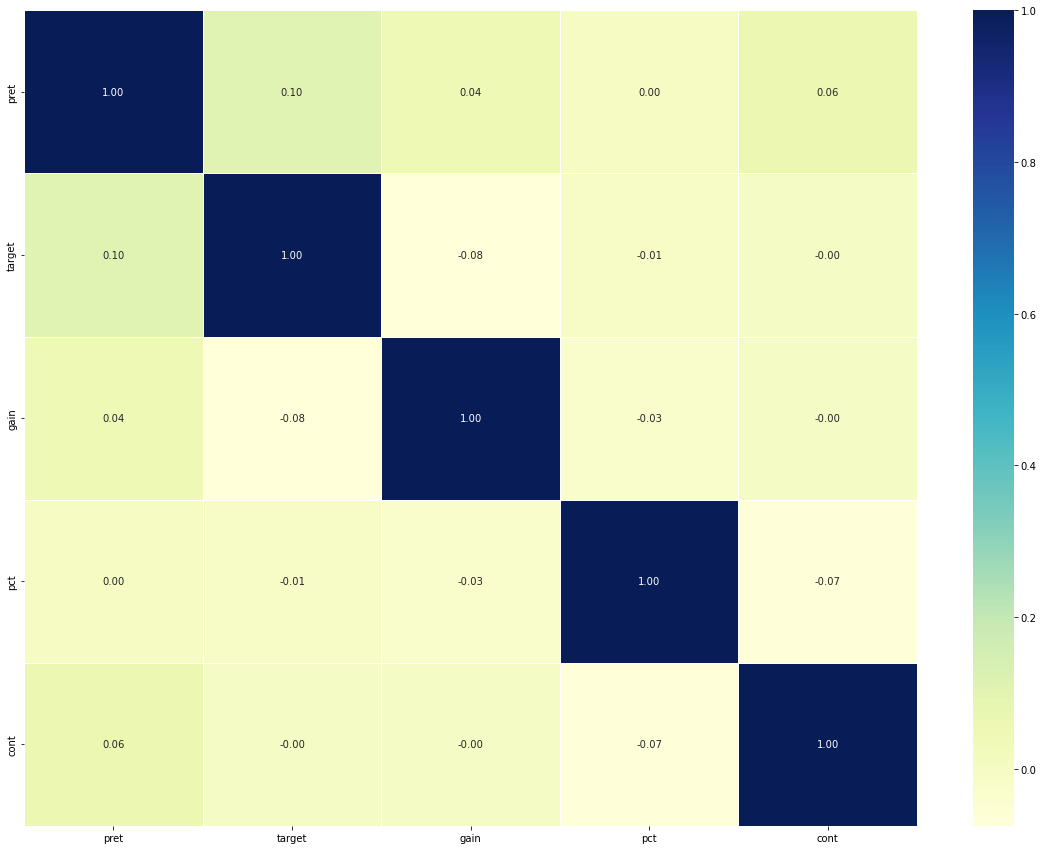

In [71]:
indicators = list(trades.columns)
# indicators.append("target")

d = trades[list(indicators)].copy()
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

In [72]:
trades.iloc[:-1000].to_csv("cont.csv")
trades.iloc[-1000:].to_csv("test.csv")